# Model comparison 4D

This notebook is used to visualize the compression errors of AEs trained on a 4-dimensional jet dataset.

In [1]:
import os
import uproot
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import corner

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from fastai.metrics import mse
from fastai.callback import schedule

import vector

import glob

In [2]:
plt.rcParams.update({'font.size': 16, 'lines.markersize' : 12, 'image.cmap' : 'tab20b'})

# Get all model names and their respective responses and residuals

In [3]:
# Use for new, run-specific directory setup
storage_path = r'F:\Master\Data\storage'

#run_nrs = [20211028201105, 20211028150801, 20211028150722, 20211028150713]
#run_nrs = [20211026113204, 20211101114815, 20211101124718, 20211104113505, 20211028201105, 20211028150801, 20211028150722, 20211028150713, 20211109204941, 20211109204942] # single + all intermediate
run_nrs = [20211101175646, 20211101175647, 20211101175649, 20211101175648, 20211102035713, 20211101175700, 20211108161124, 20211101181052, 20211101175702, 20211101175701, 20211101175706, 20211101175705, 20211101175703, 20211101175709] # all non-intermediate models except 4_9, which is in 20211101175704
#run_nrs = [20211101114815, 20211101124718, 20211104113505, 20211028201105, 20211028150801, 20211028150722, 20211028150713, 20211109204941,
#           20211109204942, 20211101175646, 20211101175647, 20211101175649, 20211101175648, 20211102035713, 20211101175700, 20211108161124,
#           20211101181052, 20211101175702, 20211101175701, 20211101175706, 20211101175705, 20211101175703, 20211101175709] # all 4D group models

orig_pred_path = {}
info_path = {}
for run_nr in run_nrs:
    folder = glob.glob(os.sep.join([storage_path, 'run_'+str(run_nr)+'*']))[0]
    orig_pred_path[run_nr] = os.sep.join([folder, 'orig-pred'])
    info_path[run_nr] = os.sep.join([folder, 'model-info'])

full_names = {}
model_names_dict = {}
for run_nr in run_nrs:
    this_path = os.sep.join([info_path[run_nr], 'run_'+str(run_nr)+'*'])
    full_names[run_nr] = []
    full_names[run_nr] += glob.glob(this_path)
    model_names_dict[run_nr] = []
    for model_name in full_names[run_nr]:
        model_names_dict[run_nr].append(model_name[model_name.rfind('run'):model_name.rfind('.info')])

In [4]:
# Use for new, run-specific directory setup
origs = {}
preds = {}
info = {}
architecture = {}
model_names = []

t = time.perf_counter()
for run_nr in run_nrs:
    for i, model_name in enumerate(model_names_dict[run_nr]):
        try:
            full_info = pd.read_pickle(os.sep.join([info_path[run_nr], model_name+'.info']))
            filename = os.sep.join([orig_pred_path[run_nr], model_name+'_orig-pred.pkl'])
            origs[model_name], preds[model_name] = pd.read_pickle(filename)
            if i == 0:
                branches = origs[model_name].columns

            info[model_name] = full_info[0]
            try:
                architecture[model_name] = full_info[2]
            except:
                print('Architecture not available for model', model_name)
            model_names.append(model_name)
        except FileNotFoundError:
            print('File not found:', filename)
        
print('Total run time:', time.perf_counter() - t, 'seconds.')
try:
    print('Intermediate setting of last model is:', info[model_name]['intermediate'])
except:
    print('No intermediate setting of last model available.')
print('Architecture of an example model:', list(architecture.items())[0])
print('Number of models:', len(model_names))

Total run time: 25.899322499999997 seconds.
Intermediate setting of last model is: False
Architecture of an example model: ('run_20211101175646_d2lep_dim_4_pt_sort_1_3', '4-200-200-100-3-100-200-200-4, activation function: Tanh()')
Number of models: 39


In [5]:
# Extract quartile, standard deviation and median information for the errors of all AE models

percentile_values = [0.5, 99.5]
#percentile_values = [0, 100]

res_type = dict(zip(branches, ['response', 'residual', 'residual', 'response']))

t = time.perf_counter()

all_res = {}
means = {}
stds = {}
boxes = {}
for model_name in model_names:
    temp_res = preds[model_name] - origs[model_name]
    means[model_name] = {'response' : {}, 'residual' : {}}
    stds[model_name] = {'response' : {}, 'residual' : {}}
    boxes[model_name] = {'response' : {}, 'residual' : {}}
    for branch in branches:
        if res_type[branch] == 'response':
            temp_res[branch] /= origs[model_name][branch]
        temp_percentiles = np.percentile(temp_res[branch], percentile_values)
        mask = (temp_res[branch] > temp_percentiles[0]) & (temp_res[branch] < temp_percentiles[1])
        means[model_name][res_type[branch]][branch] = temp_res[branch][mask].mean()
        stds[model_name][res_type[branch]][branch] = temp_res[branch][mask].std()
        
        median = np.median(temp_res[branch])
        q1 = np.median(temp_res[branch][temp_res[branch] < median])
        q3 = np.median(temp_res[branch][temp_res[branch] > median])
        iqr = q3 - q1
        low = q1 - 1.5*iqr
        high = q3 + 1.5*iqr
        lower_p = np.percentile(temp_res[branch], percentile_values[0])
        upper_p = np.percentile(temp_res[branch], percentile_values[1])
        n_outliers = sum(temp_res[branch] < low) + sum(temp_res[branch] > high)
        boxes[model_name][res_type[branch]][branch] = {'median' : median,
                                                  'q1' : q1,
                                                  'q3' : q3,
                                                  'iqr' : iqr,
                                                  'low' : low,
                                                  'high' : high,
                                                  'n_outliers' : n_outliers,
                                                  'max' : temp_res[branch].max(),
                                                  'min' : temp_res[branch].min(),
                                                  'lower_p' : lower_p,
                                                  'upper_p' : upper_p}
    all_res[model_name] = temp_res

print('Data processing time:', time.perf_counter() - t, 'seconds.')

Data processing time: 28.58395759999999 seconds.


In [6]:
info_df = pd.DataFrame(info).transpose()
info_df['comp_ratio'] = (info_df['n_features'] + info_df['intermediate']) * info_df['group_size'] / info_df['latent_space_size']
info_df = info_df.sort_values(['mode', 'comp_ratio', 'group_size'], ascending=[False, True, True])

# Masking model selection
all_model_names = np.array(list(info_df.index))

# Include only collective models and assign single model to reference_model
collective_mask = info_df['model_type'] == 'collective'
reference_df = info_df[~collective_mask]
info_df = info_df[collective_mask]

# Different masks used to view subsets of the set of AE models
#mask = [boxes[model_name]['response']['pt']['iqr'] < 0.01 for model_name in all_model_names[collective_mask]]
#mask = info_df['comp_ratio'] <= 1.34
#mask = info_df['mode'] == 'pt_sort'
#mask = (info_df['mode'] == 'random') & (info_df['comp_ratio'] > 4/3)
#mask = (info_df['comp_ratio'] > 4/3)
#mask = info_df['group_size'] != 5
mask = [True] * len(info_df)

info_df = info_df[mask]

model_names = list(info_df.index)
group_sizes = np.unique(info_df['group_size'])

In [7]:
# sort models based on iqr score and make a reduced selection
# the iqr score is calculated in the following manner:
# for each variable, calculate the inter-quartile range (iqr) of all models
# sort the list of models by their iqr
# for each model, add the index of its place in this sorted list to the iqr score of that model
# 
# so, a model with an iqr score of 0 has had the lowest iqr of all models for all variables
# in practice, no model will score the best for all variables, but the best models will have an iqr score close to zero

model_scores = dict(zip(model_names, [0] * len(model_names)))
for branch in branches:
    iqrs = []
    for model_name in model_names:
        iqrs.append(boxes[model_name][res_type[branch]][branch]['iqr'])
    iqrs = np.sort(iqrs)
    for model_name in model_names:
        model_scores[model_name] += np.where(iqrs == boxes[model_name][res_type[branch]][branch]['iqr'])[0][0]
sort_order = np.array(list(model_scores.values())).argsort()
#model_names = np.array(model_names)[sort_order]

In [8]:
comp_ratios = np.unique(info_df['comp_ratio'])
for key in np.array(list(model_scores.keys()))[sort_order]:
    this_comp_ratio = (info[key]['n_features'] + info[key]['intermediate']) * info[key]['group_size'] / info[key]['latent_space_size']
    print('{:20} {:5.2f} {:>4} {}'.format(info[key]['name'], this_comp_ratio, model_scores[key], info[key]['intermediate']))

random_1_3            1.33    2 False
same_event_1_3        1.33    9 False
pt_sort_2_6           1.33   10 False
pt_sort_1_3           1.33   12 False
pt_sort_2_5           1.60   21 False
pt_sort_3_9           1.33   29 False
random_2_6            1.33   30 False
pt_sort_3_8           1.50   36 False
random_3_9            1.33   39 False
pt_sort_4_11          1.45   41 False
same_event_2_6        1.33   43 False
pt_sort_4_12          1.33   46 False
pt_sort_3_7           1.71   46 False
pt_sort_5_15          1.33   48 False
pt_sort_5_14          1.43   53 False
pt_sort_5_12          1.67   55 False
random_4_12           1.33   60 False
random_5_15           1.33   61 False
pt_sort_5_13          1.54   80 False
same_event_3_9        1.33   80 False
random_3_8            1.50   82 False
random_2_5            1.60   83 False
random_4_11           1.45   86 False
pt_sort_4_10          1.60   86 False
random_5_14           1.43   88 False
same_event_4_12       1.33  104 False
random_5_13 

In [9]:
for branch in branches[:1]:
    print(branch)
    print(';'.join(['model_name', 'iqr', 'median', 'high_p-low_p']))
    for model_name in model_names:
        comp_ratio = (info[model_name]['n_features'] + info[model_name]['intermediate']) * info[model_name]['group_size'] / info[model_name]['latent_space_size']
        if True: #not comp_ratio == 4/3:
            iqr = str(boxes[model_name][res_type[branch]][branch]['iqr'])
            median = str(boxes[model_name][res_type[branch]][branch]['median'])
            p_range = str(boxes[model_name][res_type[branch]][branch]['upper_p'] - boxes[model_name][res_type[branch]][branch]['lower_p'])
            #print(';'.join([model_name, str(comp_ratio)]))
            print('{:.2f}'.format(comp_ratio))

pt
model_name;iqr;median;high_p-low_p
1.33
1.33
1.33
1.33
1.33
1.43
1.45
1.50
1.54
1.60
1.60
1.67
1.71
1.33
1.33
1.33
1.33
1.33
1.43
1.45
1.50
1.54
1.60
1.60
1.67
1.71
1.33
1.33
1.33
1.33
1.33
1.43
1.45
1.50
1.54
1.60
1.60
1.67
1.71


# Box plots of all responses and residuals

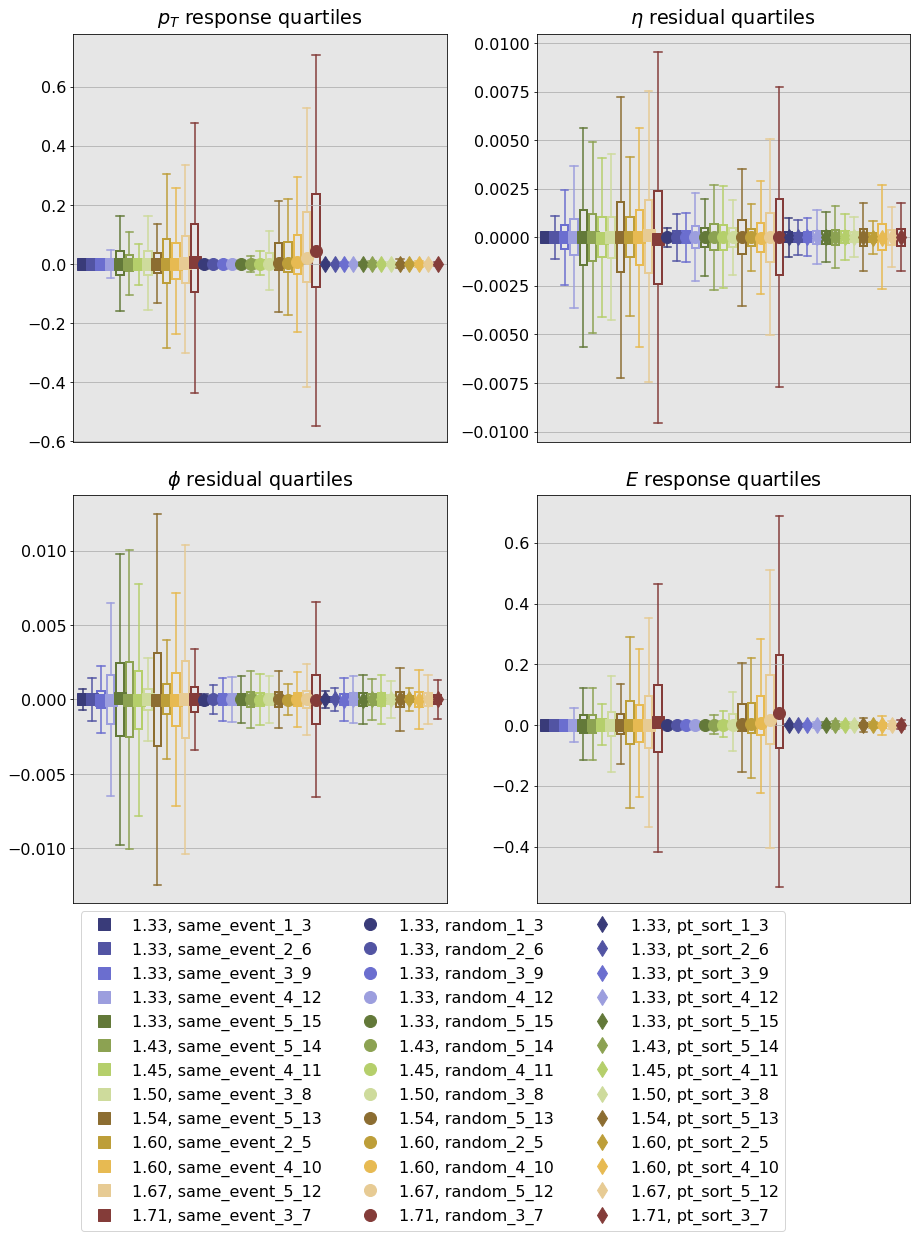

In [10]:
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

modes = np.array(['same_event', 'random', 'pt_sort'])

markers = {'same_event' : 's',
           'random' : 'o',
           'pt_sort' : 'd'}

# Use either iqr or percentiles to define whiskers
whisker_def = ['low', 'high'] # iqr outlier definition
#whisker_def = ['lower_p', 'upper_p'] # percentile outlier definition

# For residuals
n_plots = len(branches)
max_mode_n = max([sum(info_df['mode'] == mode) for mode in modes])
if max_mode_n <= 10:
    colors = plt.get_cmap('tab20b').colors[::2][:max_mode_n]
elif max_mode_n <= 20:
    colors = plt.get_cmap('tab20b').colors[:max_mode_n]
else:
    colors = plt.get_cmap('tab20b').colors + plt.get_cmap('tab20c').colors
prev_mode = ''
col = 0
fig = plt.figure(figsize = (15, 16))
for pos, model_name in enumerate(info_df.index):
    
    if info[model_name]['mode'] != prev_mode:
        col = 0
    color = colors[col]
    
    for plot, branch in enumerate(branches):
        ax = plt.subplot(2, 2, plot+1)
        
        box = boxes[model_name][res_type[branch]][branch]
        
        top = box[whisker_def[1]] + 0.1*np.abs(box[whisker_def[1]])
        bot = box[whisker_def[0]] - 0.1*np.abs(box[whisker_def[0]])
        
        #top = box['max'] + 0.1*np.abs(box['max'])
        #bot = box['min'] - 0.1*np.abs(box['min'])
        
        if pos == 0:
            ax.set_ylim((bot, top))
        else:
            y_bot, y_top = ax.get_ylim()        
            if top > y_top:
                y_top = top
            if bot < y_bot:
                y_bot = bot
            ax.set_ylim((y_bot, y_top))
        
        rect_width = 0.8
        rect_corner = (pos-rect_width/2, box['q1'])
        rect_height = box['q3'] - box['q1']
        ax.add_patch(Rectangle(rect_corner, rect_width, rect_height, linewidth=2, edgecolor=color, facecolor='none'))
        
        ax.add_line(Line2D((pos-rect_width/2, pos+rect_width/2), (box[whisker_def[1]], box[whisker_def[1]]), color=color))
        ax.add_line(Line2D((pos-rect_width/2, pos+rect_width/2), (box[whisker_def[0]], box[whisker_def[0]]), color=color))
        ax.add_line(Line2D((pos, pos), (box['q3'], box[whisker_def[1]]), color=color))
        ax.add_line(Line2D((pos, pos), (box['q1'], box[whisker_def[0]]), color=color))
        
        # Using max and min instead of high and low
        #ax.add_line(Line2D((pos-rect_width/2, pos+rect_width/2), (box['max'], box['max']), color=color))
        #ax.add_line(Line2D((pos-rect_width/2, pos+rect_width/2), (box['min'], box['min']), color=color))
        #ax.add_line(Line2D((pos, pos), (box['q3'], box['max']), color=color))
        #ax.add_line(Line2D((pos, pos), (box['q1'], box['min']), color=color))
        
        plt.plot(pos, box['median'], linewidth=0, marker=markers[info[model_name]['mode']], color=color, label='{comp_ratio:.2f}, {info}'.format(info=info[model_name]['name'] + '_int' * info[model_name]['intermediate'], comp_ratio=info_df.iloc[pos]['comp_ratio']))
    
    col += 1
    prev_mode = info[model_name]['mode']
        
branch_symbols = dict(zip(branches, ['$p_T$', '$\eta$', '$\phi$', '$E$']))
        
for plot, branch in enumerate(branches):
    plt.subplot(2, 2, plot+1)
    ax = plt.gca()
    
    x_min = -1
    if list(reference_df.values) != []:
        box = boxes[list(reference_df.index)[0]][res_type[branch]][branch]
        
        color='k'
        pos = -1
        x_min = -2
        
        top = box[whisker_def[1]] + 0.1*np.abs(box[whisker_def[1]])
        bot = box[whisker_def[0]] - 0.1*np.abs(box[whisker_def[0]])
        
        #top = box['max'] + 0.1*np.abs(box['max'])
        #bot = box['min'] - 0.1*np.abs(box['min'])
        
        if pos == 0:
            ax.set_ylim((bot, top))
        else:
            y_bot, y_top = ax.get_ylim()        
            if top > y_top:
                y_top = top
            if bot < y_bot:
                y_bot = bot
            ax.set_ylim((y_bot, y_top))
        
        rect_width = 0.8
        rect_corner = (pos-rect_width/2, box['q1'])
        rect_height = box['q3'] - box['q1']
        
        # Box
        ax.add_patch(Rectangle(rect_corner, rect_width, rect_height, linewidth=2, edgecolor=color, facecolor='none'))
        
        # Caps
        ax.add_line(Line2D((pos-rect_width/2, pos+rect_width/2), (box[whisker_def[1]], box[whisker_def[1]]), color=color))
        ax.add_line(Line2D((pos-rect_width/2, pos+rect_width/2), (box[whisker_def[0]], box[whisker_def[0]]), color=color))
        
        # Whiskers
        ax.add_line(Line2D((pos, pos), (box['q3'], box[whisker_def[1]]), color=color))
        ax.add_line(Line2D((pos, pos), (box['q1'], box[whisker_def[0]]), color=color))
        
        # Marker on median
        plt.plot(pos, box['median'], linewidth=0, marker='H', color=color, label='{comp_ratio:.2f}, {info}'.format(info='single compression', comp_ratio=reference_df['comp_ratio'].values[0]))
    
    plt.gca().set_facecolor((0.9, 0.9, 0.9))
    
    quantile_str = 'quantiles'
    if whisker_def[0] == 'low':
        quantile_str = 'quartiles'
    
    ax.set_title(branch_symbols[branch] + ' ' + res_type[branch] + ' ' + quantile_str, pad=10)
    ax = plt.gca()
    ax.set_xlim((x_min, len(model_names)))
    ax.set_xticks([])
    plt.grid(axis='y')
    
    if plot == 2:
        ncol = 3
        if sum(info_df['mode'] == 'same_event') == 0:
            ncol = 1
        handles, labels = ax.get_legend_handles_labels()
        if list(reference_df.values) != []:
            handles = [handles[-1]] + handles[:-1]
            labels = [labels[-1]] + labels[:-1]
        plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(0, 0), ncol=ncol);

plt.subplots_adjust(hspace=0.13, wspace=0.24)

(101156, 4) (101156, 4)
-0.10730629786849022 0.16700829938054085 -0.5187463164329529 0.5783883929252625
-0.0030257701873779297 0.002912282943725586 -0.011930108070373535 0.011819243431091309
-0.0018459111452102661 0.0018253326416015625 -0.007352352142333984 0.007331371307373047
-0.11485540308058262 0.15895136073231697 -0.5254765152931213 0.5696115493774414


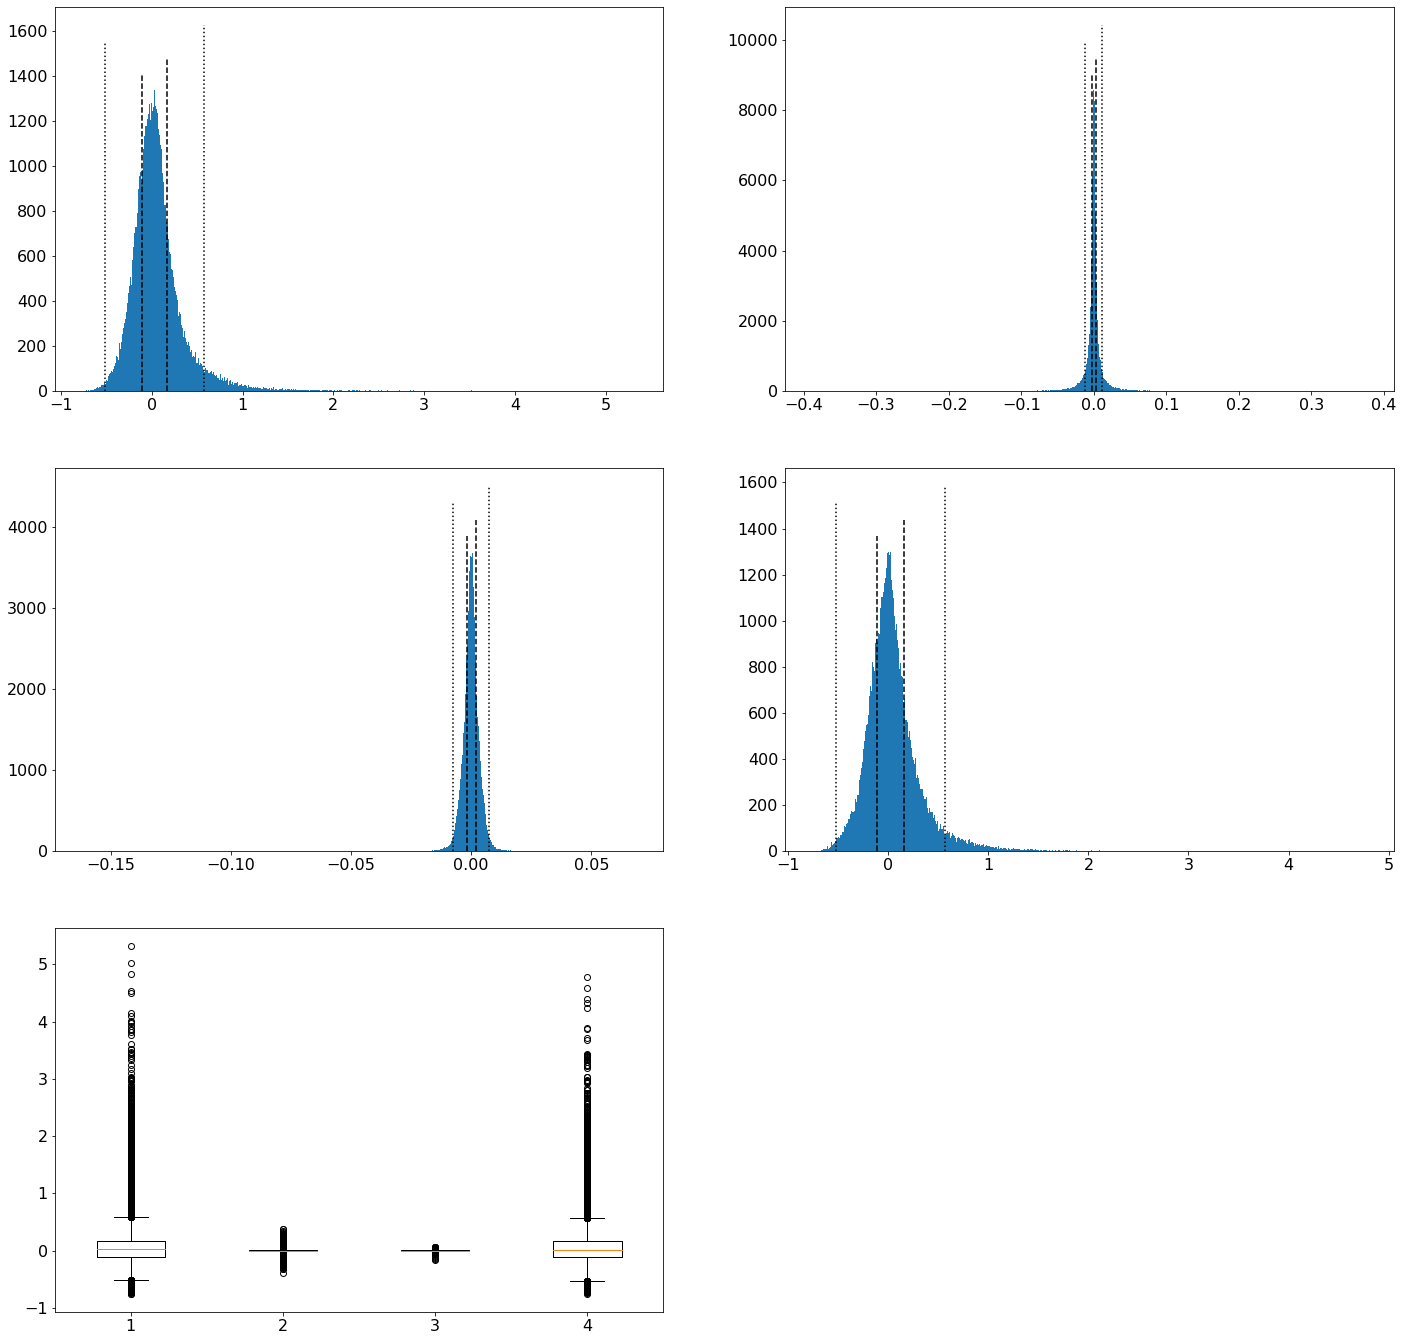

In [73]:
# view responses and residuals of a specific model, with quartiles marked

fig = plt.figure(figsize=(24, 24))
model_name = 'run_20211101175704_d2lep_dim_4_same_event_4_9'
temp_res = preds[model_name] - origs[model_name]
print(temp_res.shape, origs[model_name].shape)
for i, branch in enumerate(branches):
    if res_type[branch] == 'response':
        temp_res[branch] /= origs[model_name][branch]
plt.subplot(3, 2, 5)
boxen = plt.boxplot(temp_res)
for i, branch in enumerate(branches):
    plt.subplot(3, 2, i+1)
    plt.hist(temp_res[branch], bins=1000)
    #plt.yscale('log')
    q1 = boxen['boxes'][i].get_data()[1][0]
    q3 = boxen['boxes'][i].get_data()[1][2]
    low = boxen['caps'][2 * i].get_data()[1][0]
    high = boxen['caps'][2*i + 1].get_data()[1][0]
    plt.vlines(q1, plt.ylim()[0], plt.ylim()[1], 'k', '--')
    plt.vlines(q3, plt.ylim()[0], plt.ylim()[1], 'k', '--')
    plt.vlines(low, plt.ylim()[0], plt.ylim()[1], 'k', ':')
    plt.vlines(high, plt.ylim()[0], plt.ylim()[1], 'k', ':')
    #plt.xlim([-0.01, 0.01])
    print(q1, q3, low, high)

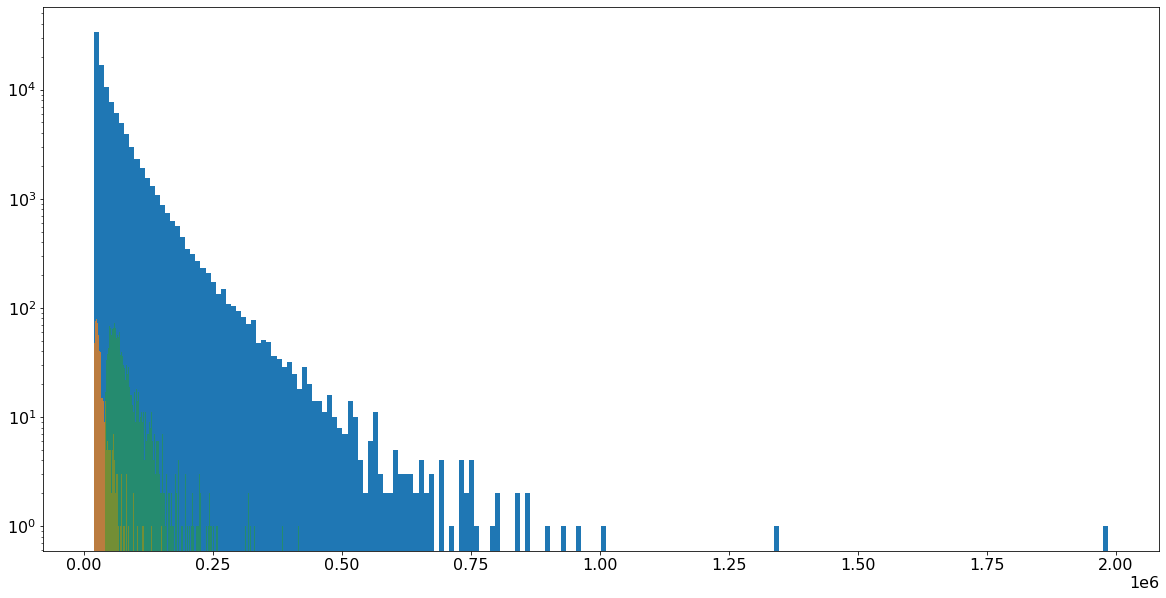

In [86]:
# view distributions of jets with given error properties

fig = plt.figure(figsize=(20, 10))
n_bins = 200
_ = plt.hist(origs[model_name]['pt'], bins=n_bins)
plt.yscale('log')
mask = temp_res['pt'] > 1
_ = plt.hist(origs[model_name]['pt'][mask], bins=n_bins, alpha = 0.7)
_ = plt.hist(preds[model_name]['pt'][mask], bins=n_bins, alpha = 0.5)

In [13]:
# Find iqr of all models and branches, and the model with the minimum iqr for each branch
max_len = max([len(model_name) for model_name in model_names])
min_iqr = {}
for branch in branches:
    print(branch)
    min_iqr[branch] = (np.inf, '')
    for model_name in model_names:
        iqr = boxes[model_name][res_type[branch]][branch]['q3']-boxes[model_name][res_type[branch]][branch]['q1']
        if iqr < min_iqr[branch][0]:
            min_iqr[branch] = (iqr, model_name)
        print('{model_name:<{max_len}} {iqr:.5f}'.format(model_name=model_name, max_len=max_len+1, iqr=iqr))
    print()
for branch in branches:
    print(branch, min_iqr[branch])

pt
run_20211109204942_d2lep_dim_4_same_event_5_14  0.01737
run_20211109204941_d2lep_dim_4_same_event_4_11  0.02481
run_20211028201105_d2lep_dim_4_same_event_3_8   0.04375
run_20211028150713_d2lep_dim_4_same_event_5_13  0.06546
run_20211101114815_d2lep_dim_4_same_event_2_5   0.10490
run_20211028150801_d2lep_dim_4_same_event_4_10  0.08373
run_20211028150722_d2lep_dim_4_same_event_5_12  0.12857
run_20211101124718_d2lep_dim_4_same_event_3_7   0.19484
run_20211109204942_d2lep_dim_4_random_5_14      0.01656
run_20211109204941_d2lep_dim_4_random_4_11      0.03901
run_20211028201105_d2lep_dim_4_random_3_8       0.06029
run_20211028150713_d2lep_dim_4_random_5_13      0.09674
run_20211101114815_d2lep_dim_4_random_2_5       0.10485
run_20211028150801_d2lep_dim_4_random_4_10      0.15115
run_20211028150722_d2lep_dim_4_random_5_12      0.20313
run_20211101124718_d2lep_dim_4_random_3_7       0.20903
run_20211109204942_d2lep_dim_4_pt_sort_5_14     0.00309
run_20211109204941_d2lep_dim_4_pt_sort_4_11  

### Plotting differences between Nx4 and Nx(4-3)

In [234]:
reduced_model_names = []
model_labels = []
for model_name in model_names:
    comp_ratio = (info[model_name]['n_features'] + info[model_name]['intermediate']) * info[model_name]['group_size'] / info[model_name]['latent_space_size']
    if comp_ratio != 4/3:
        this_name = info[model_name]['name']
        if info[model_name]['intermediate']:
            this_name += '_int'
        reduced_model_names.append(model_name)
        model_labels.append(this_name)

reduced_model_names = np.array(reduced_model_names)
model_labels = np.array(model_labels)

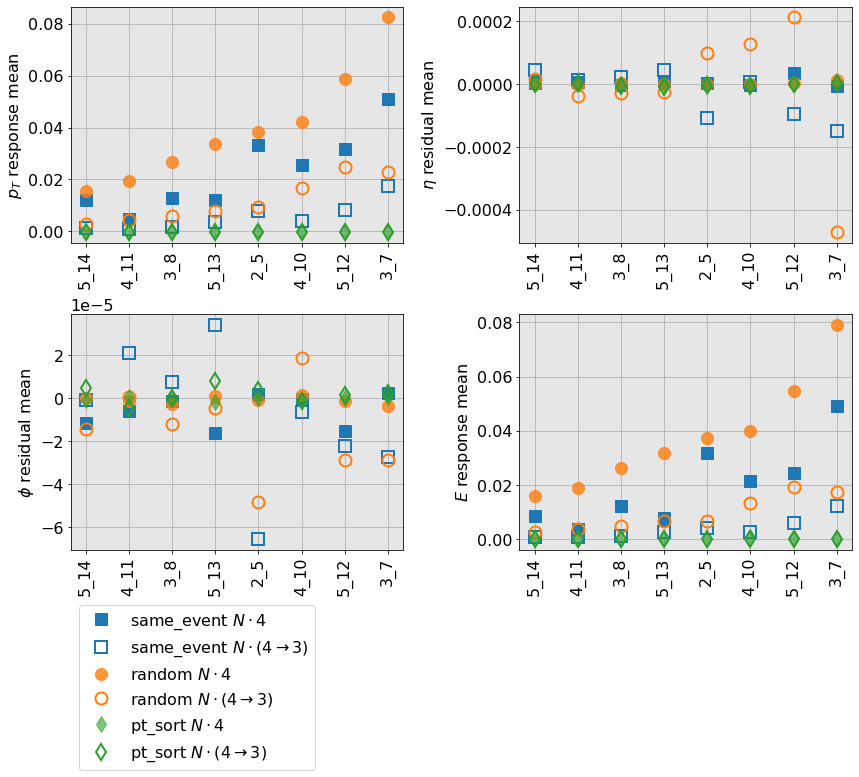

In [303]:
branch_symbols = dict(zip(branches, ['$p_T$', '$\eta$', '$\phi$', '$E$']))

fig = plt.figure(figsize=(14, 10))
x_labels = model_labels[info_df['mode'] == 'same_event']
x_labels = [x_label[x_label.rfind('t_') + 2:] for x_label in x_labels[1::2]]

for b, branch in enumerate(branches):
    
    plt.subplot(2, 2, b+1)
    
    for m, mode in enumerate(modes):
    
        mode_mask = info_df['mode'] == mode
        int_mask = np.array(['int' in model_label for model_label in model_labels[mode_mask]])
        
        std_list = []
        mean_list = []
        for model_name in reduced_model_names[mode_mask]:
                std_list.append(stds[model_name][res_type[branch]][branch])
                mean_list.append(means[model_name][res_type[branch]][branch])

        std_list = np.array(std_list)
        mean_list = np.array(mean_list)

        plot = plt.plot(x_labels, mean_list[~int_mask], marker=markers[mode], linestyle='none', label=mode + r' $N \cdot 4$', alpha=1-m*.2)
        #plt.plot(model_labels[~int_mask], mean_list[~int_mask], 'P', color=(.5, .5, .5), label=r'$N \cdot 4$ mean')

        plt.plot(x_labels, mean_list[int_mask], color=plot[0].get_c(), marker=markers[mode], markerfacecolor='none', markeredgewidth=2, linestyle='none', label=mode + r' $N \cdot (4 \rightarrow 3)$')
        #plt.plot(model_labels[~int_mask], mean_list[int_mask], 'o', markeredgecolor='b', markerfacecolor='none', label=r'$N \cdot (4 \rightarrow 3)$ mean')

    #plt.yscale('log')
    plt.xticks(rotation=90);
    plt.ylabel(branch_symbols[branch] + ' ' + res_type[branch] + ' mean')
    plt.gca().set_facecolor((0.9, 0.9, 0.9))
    plt.grid()
    
    if b == 2:
        plt.legend(loc=2, bbox_to_anchor=(0, -.2))

plt.subplots_adjust(hspace=0.3, wspace=0.35)


In [41]:
#model_name = 'run_20211101175648_d2lep_dim_4_same_event_3_9'
#model_name = 'run_20211102035713_d2lep_dim_4_same_event_3_8'
#model_name = 'run_20211101175700_d2lep_dim_4_same_event_3_7'

#model_name = 'run_20211101175649_d2lep_dim_4_pt_sort_2_5'

#model_name = 'run_20211101175700_d2lep_dim_4_same_event_3_7'
#model_name = 'run_20211108161124_d2lep_dim_4_pt_sort_3_7'
#model_name = 'run_20211101175700_d2lep_dim_4_random_3_7'

#model_name = 'run_20211101175703_d2lep_dim_4_same_event_5_13'
#model_name = 'run_20211101175703_d2lep_dim_4_pt_sort_5_13'

model_name = 'run_20211101175706_d2lep_dim_4_same_event_5_15'
#model_name = 'run_20211101175705_d2lep_dim_4_same_event_5_14'
#model_name = 'run_20211101175703_d2lep_dim_4_same_event_5_13'
#model_name = 'run_20211101175709_d2lep_dim_4_same_event_5_12'

#model_name = 'run_20211101181052_d2lep_dim_4_same_event_4_12'
#model_name = 'run_20211101175702_d2lep_dim_4_same_event_4_11'
#model_name = 'run_20211101175701_d2lep_dim_4_same_event_4_10'

res = all_res[model_name]
group_size = info[model_name]['group_size']
jets = []
for i in range(group_size):
    jets.append(res.iloc[i::group_size])

same_event_5_15


1 0 -0.6825005790946499
2 0 0.4820400246156042
2 1 -0.6456395382025817
3 0 -0.40787002760289365
3 1 0.5451416445091772
3 2 -0.6459734153290946
4 0 -0.33434809324960124
4 1 0.39698704437418986
4 2 -0.4831432321075054
4 3 0.42275337501065113


1 0 0.08399733908255536
2 0 0.027589783431307316
2 1 0.06632980826816187
3 0 0.019513418701922355
3 1 0.016256715121759756
3 2 0.00335399386416162
4 0 0.05720446418399619
4 1 0.02219615049571762
4 2 0.06727886155102711
4 3 0.038572722176060725


1 0 -0.13836341599036056
2 0 -0.11504454374351222
2 1 -0.010650387570286706
3 0 -0.07196723506235765
3 1 0.07131469746503746
3 2 0.10354389788922211
4 0 -0.04974536402420364
4 1 -0.04118769513920508
4 2 -0.03910996661503696
4 3 -0.03395784956807973
1 0 0.4662766161971096
2 0 0.015978590127154645
2 1 0.43491470490349554
3 0 -0.007329256185740905
3 1 -0.3298915150443231
3 2 -0.7076310716734462
4 0 -0.035033745606128944
4 1 -0.20920086815526992
4 2 -0.4657853143420339
4 3 0.3344892548143688


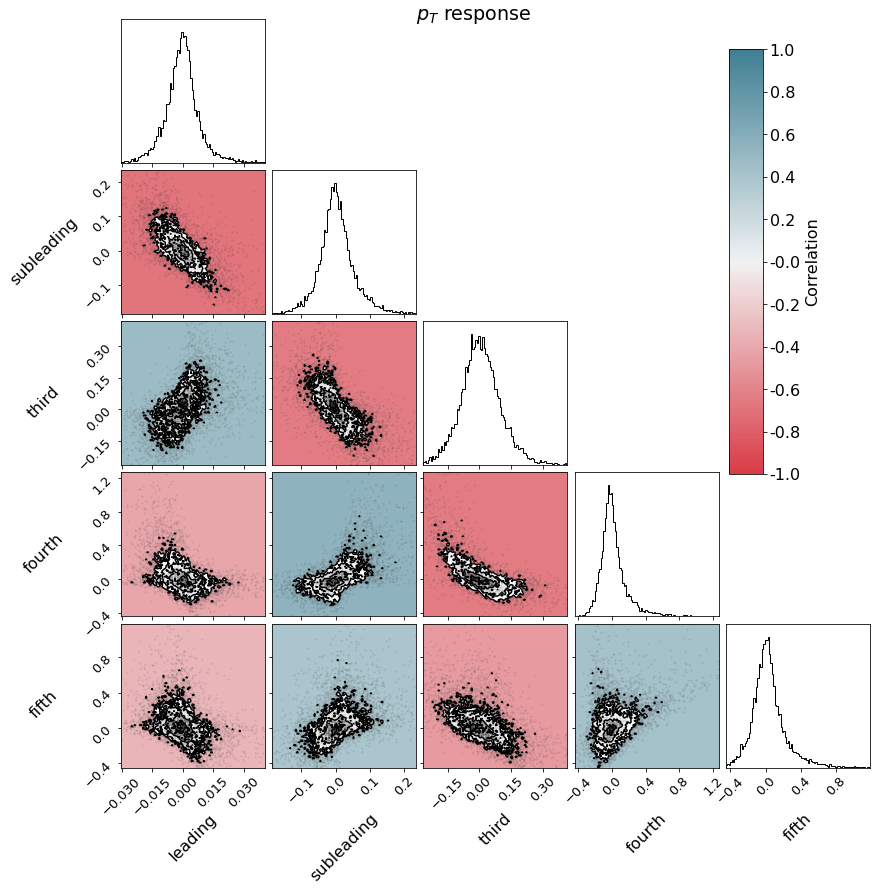

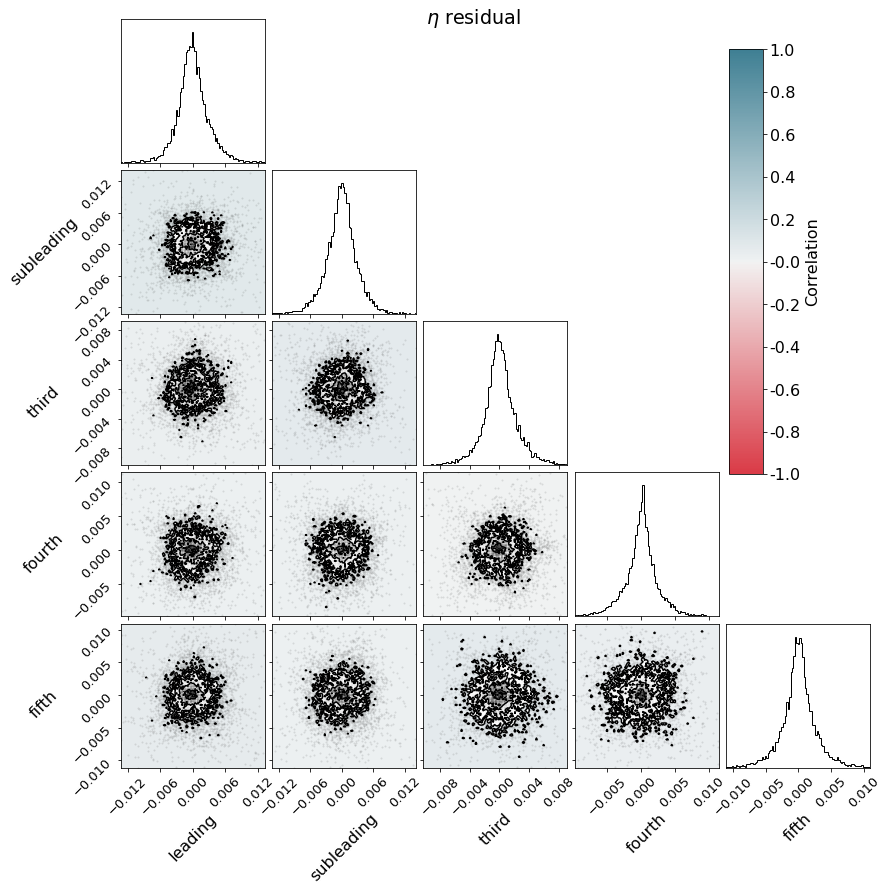

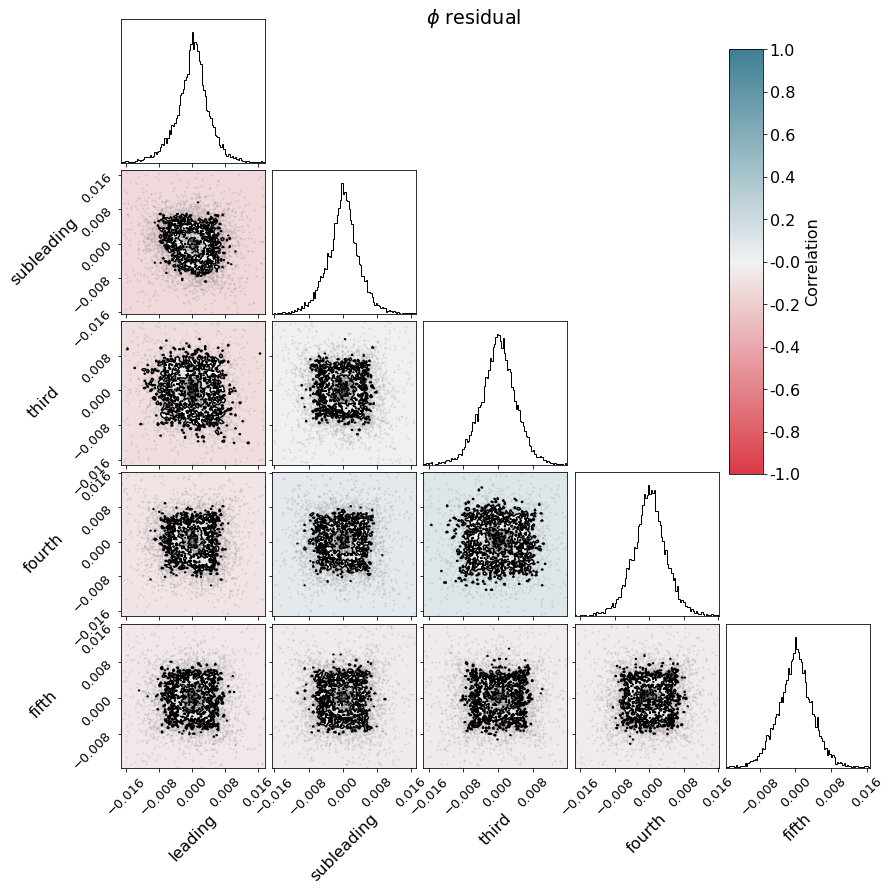

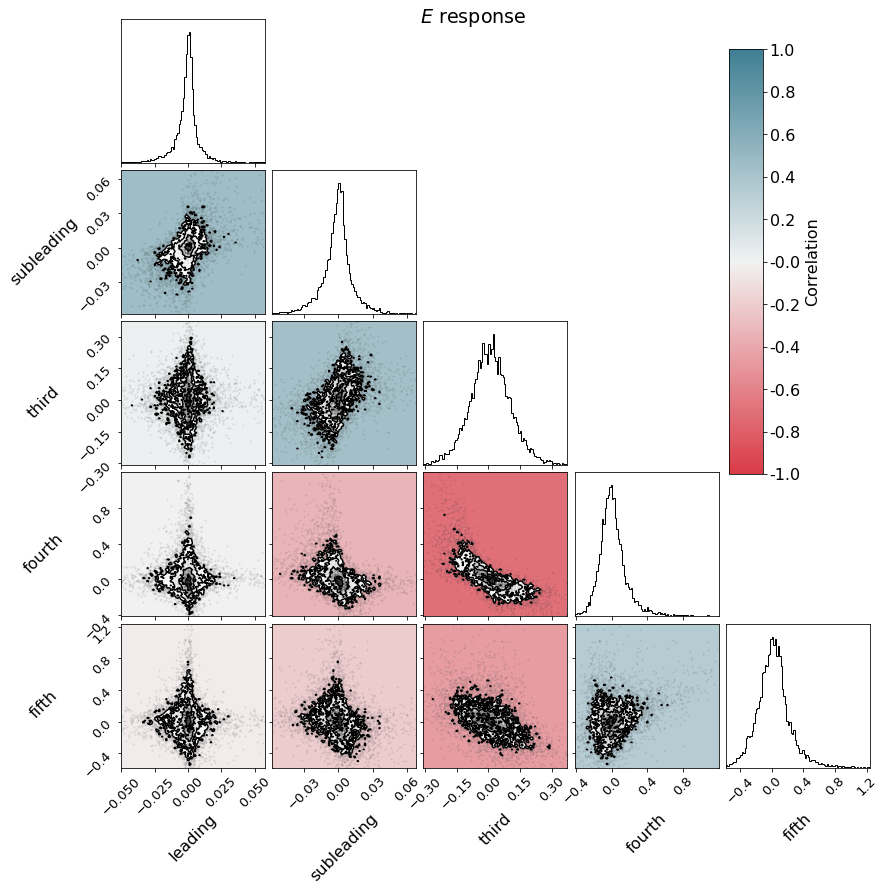

In [42]:
print(info[model_name]['name'])

jet_names = ['leading', 'subleading', 'third', 'fourth', 'fifth']
branch_labels = dict(zip(branches, ['$p_T$', '$\eta$', '$\phi$', '$E$']))

n_jets = len(jets)
for b, branch in enumerate(branches):
    jet_df = pd.DataFrame(dict(zip(jet_names[:group_size], [jet[branch].values for jet in jets])))
    #jet_df = pd.DataFrame(dict(zip(branches, [jet[branch].values for branch in branches])))
    figure = corner.corner(jet_df, bins=100, range=[.995 for _ in range(group_size)], label_kwargs={'rotation' : 45})
    #figure = corner.corner(jet_df, bins=100, range=[.995 for _ in range(len(branches))], label_kwargs={'rotation' : 45})
    figure.suptitle(branch_labels[branch] + ' ' + res_type[branch])
    
    ndim = jet_df.shape[1]#group_size
    cmap = sns.diverging_palette(10, 220, as_cmap=True)
    norm = plt.Normalize(-1, 1)

    axes = figure.axes
    for ax in axes:
        labels = (ax.get_xlabel(), ax.get_ylabel())
        ax.set_xlabel(labels[0], position=(.5, -.3))
        ax.set_ylabel(labels[1], position=(-.5, .4))
        ax.tick_params(axis='both', labelsize=13)
    axes = np.array(axes).reshape(ndim, ndim)
    for y in range(1, ndim):
        for a, ax in enumerate(axes[y, :y]):
            corr = jet_df.corr().iloc[y, a]
            color = cmap(norm(corr))
            ax.set_facecolor(color)
            print(y, a, corr)

    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    cax = figure.add_axes([.8, .43, .04, 0.5])
    cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
    cbar.ax.set_ylabel('Correlation');